### Variablen

Raussuchen:
- Veranstaltungen (Weihnachtsmarkt, Dom (Freimärkte), Fußballspiele, Sonstige) -> Luisa

### Werktage und Wochenende dummie codierung


In [15]:
import pandas as pd

# CSV-Datei laden
csv_file = "/workspaces/DS_ML_Gr_1.5/0_DataPreparation/00_archive/merged_data_wo_werktage.csv"
df_wt = pd.read_csv(csv_file)

# Zeitraum definieren, wo die Spalte 'Wochentag' erweitert werden muss
start_date = "2018-08-01"
end_date = "2019-07-30"

# Datumsbereich erstellen
date_range = pd.date_range(start=start_date, end=end_date)

# DataFrame mit dem Datumsbereich erstellen
df_dates = pd.DataFrame({'Datum': date_range})

# Wochentage auf Englisch hinzufügen
df_dates['Wochentag'] = df_dates['Datum'].dt.day_name()

# Sicherstellen, dass das Datum in beiden DataFrames kompatibel ist
df_wt['Datum'] = pd.to_datetime(df_wt['Datum'])  # Konvertiere 'Datum' zu datetime

# Prüfen, ob neue Daten schon im bestehenden DataFrame enthalten sind
existing_dates = set(df_wt['Datum'])
new_dates = set(df_dates['Datum'])

# Nur die neuen Datumswerte hinzufügen
df_new = df_dates[df_dates['Datum'].isin(new_dates - existing_dates)]

# Zusammenfügen des ursprünglichen DataFrames mit den neuen Daten
df_combined = pd.concat([df_wt, df_new], ignore_index=True)

# Fülle die Spalte 'Wochentag' erneut für alle Daten
df_combined['Wochentag'] = df_combined['Datum'].dt.day_name()

# Werktag-Spalte basierend auf den englischen Wochentagen hinzufügen
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df_combined['Werktag'] = df_combined['Wochentag'].apply(lambda x: 1 if x in weekdays else 0)

In [16]:
#Hinzufügen der One-Hot Codierung für die fehlende Wochentage bis 2019-07-31
# One-Hot-Codierung für Wochentage ergänzen
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in days:
    df_combined[day] = df_combined['Wochentag'].apply(lambda x: 1 if x == day else 0)

In [17]:
# CSV-Datei speichern
output_file = "/workspaces/DS_ML_Gr_1.5/0_DataPreparation/merged_data_new_Wochentag.csv"
df_combined.to_csv(output_file, index=False)

print(f"Daten erfolgreich erweitert und in {output_file} gespeichert.")

Daten erfolgreich erweitert und in /workspaces/DS_ML_Gr_1.5/0_DataPreparation/merged_data_new_Wochentag.csv gespeichert.



### Frühjahrs- und Herbstmärkte Kiel
Erstellung des csv.files "veranstaltung_kiel" mit Veranstaltungen aus jahrmarktnord.de

In [1]:
from bs4 import BeautifulSoup as bs
import requests
import csv
import re

In [2]:
import requests
from bs4 import BeautifulSoup
import csv
import re
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor

def fetch_and_extract_data():
    # URL der Webseite
    base_url = 'https://jahrmarktnord.de/category/archiv'  # Standard-Archiv-URL
    year_2019_url = 'https://jahrmarktnord.de/2019/'  # Spezielle URL für 2019
    event_data = []

    # Abruf der 2019-Daten
    print(f"Durchsuche 2019-Seite: {year_2019_url}")
    response = requests.get(year_2019_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        extract_events_from_page(soup, event_data)
    else:
        print(f"Fehler beim Abrufen der 2019-Seite. Status Code: {response.status_code}")

    # Abruf der archivierten Jahre mit paralleler Verarbeitung (für alle 83 Seiten)
    max_pages = 83  # 83 Seiten durchsuchen
    print(f"Durchsuche archivierte Seiten bis Seite {max_pages}...")

    # Paralleles Abrufen der Seiten
    with ThreadPoolExecutor() as executor:
        urls = [f"{base_url}/page/{i}/" for i in range(1, max_pages + 1)]
        responses = list(executor.map(fetch_page, urls))
    
    # Extrahieren der Daten von allen Seiten
    for response in responses:
        if response:
            soup = BeautifulSoup(response.text, 'html.parser')
            extract_events_from_page(soup, event_data)

    # Daten in CSV speichern
    if event_data:
        write_to_csv(event_data)
    else:
        print("Keine relevanten Veranstaltungen gefunden.")

def fetch_page(url):
    """
    Abrufen einer Seite. Rückgabe der Response bei Erfolg, sonst None.
    """
    try:
        print(f"Abrufen von {url}")
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            return response
        else:
            print(f"Fehler beim Abrufen von {url}. Status Code: {response.status_code}")
    except requests.RequestException as e:
        print(f"Request-Fehler bei {url}: {e}")
    return None

def extract_events_from_page(soup, event_data):
    """
    Extrahiert Veranstaltungsdaten aus einer BeautifulSoup-Seite und fügt sie der event_data-Liste hinzu,
    aber nur, wenn "Kiel" im Titel vorkommt.
    """
    events = soup.find_all('article')
    for event in events:
        title_tag = event.find('h3', class_='entry-title')
        if title_tag:
            title = title_tag.text.strip()
            if "Kiel" in title:
                excerpt_tag = event.find('div', class_='mh-excerpt')
                if excerpt_tag:
                    excerpt_text = excerpt_tag.text.strip()
                    date_match = re.search(r'(\d{2}\.\d{2})(?:-(\d{2}\.\d{2})(?:\.(\d{4}))?)?', excerpt_text)
                    if date_match:
                        start_date_raw = date_match.group(1)
                        end_date_raw = date_match.group(2)
                        year = date_match.group(3) or extract_year_from_title(title) or str(datetime.now().year)
                        start_date = parse_date(start_date_raw, year)
                        end_date = parse_date(end_date_raw or start_date_raw, year)
                        event_data.append([title, start_date, end_date])

def extract_year_from_title(title):
    match = re.search(r'(\d{4})', title)
    if match:
        return match.group(1)
    return None

def parse_date(date_str, year):
    try:
        if '.' in date_str:
            date_obj = datetime.strptime(f"{date_str}.{year}", "%d.%m.%Y")
            return date_obj.strftime("%Y-%m-%d")
    except ValueError as e:
        print(f"Fehler beim Parsen des Datums '{date_str}': {e}")
    return None

def write_to_csv(data):
    with open('veranstaltungen_kiel_.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Event Name', 'Start Date (YYYY-MM-DD)', 'End Date (YYYY-MM-DD)'])
        writer.writerows(data)
        print("Daten wurden erfolgreich in die CSV-Datei geschrieben!")

# Aufruf der Funktion
fetch_and_extract_data()


Durchsuche 2019-Seite: https://jahrmarktnord.de/2019/
Durchsuche archivierte Seiten bis Seite 83...
Abrufen von https://jahrmarktnord.de/category/archiv/page/1/
Abrufen von https://jahrmarktnord.de/category/archiv/page/2/
Abrufen von https://jahrmarktnord.de/category/archiv/page/3/
Abrufen von https://jahrmarktnord.de/category/archiv/page/4/
Abrufen von https://jahrmarktnord.de/category/archiv/page/5/
Abrufen von https://jahrmarktnord.de/category/archiv/page/6/
Abrufen von https://jahrmarktnord.de/category/archiv/page/7/
Abrufen von https://jahrmarktnord.de/category/archiv/page/8/
Abrufen von https://jahrmarktnord.de/category/archiv/page/9/
Abrufen von https://jahrmarktnord.de/category/archiv/page/10/
Abrufen von https://jahrmarktnord.de/category/archiv/page/11/
Abrufen von https://jahrmarktnord.de/category/archiv/page/12/
Abrufen von https://jahrmarktnord.de/category/archiv/page/13/
Abrufen von https://jahrmarktnord.de/category/archiv/page/14/
Abrufen von https://jahrmarktnord.de/cate

In [3]:
import requests
from bs4 import BeautifulSoup
import csv
import re
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor

def fetch_and_extract_data():
    base_url = 'https://jahrmarktnord.de/category/archiv'  # Archive URL
    year_2019_url = 'https://jahrmarktnord.de/2019/'  # Special URL for 2019
    event_data = []

    # Fetch 2019 data
    print(f"Fetching 2019 page: {year_2019_url}")
    response = requests.get(year_2019_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        extract_events_from_page(soup, event_data)
    else:
        print(f"Error fetching 2019 page. Status Code: {response.status_code}")

    # Fetch archive years
    max_pages = 10
    print(f"Fetching archive pages up to page {max_pages}...")

    with ThreadPoolExecutor() as executor:
        urls = [f"{base_url}/page/{i}/" for i in range(1, max_pages + 1)]
        responses = list(executor.map(fetch_page, urls))
    
    for response in responses:
        if response:
            soup = BeautifulSoup(response.text, 'html.parser')
            extract_events_from_page(soup, event_data)

    # Write to CSV
    if event_data:
        write_to_csv(event_data)
    else:
        print("No relevant events found.")

def fetch_page(url):
    """
    Fetch a single page. Return the response if successful, otherwise None.
    """
    try:
        print(f"Fetching {url}")
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            return response
        else:
            print(f"Error fetching {url}. Status Code: {response.status_code}")
    except requests.RequestException as e:
        print(f"Request error on {url}: {e}")
    return None

def extract_events_from_page(soup, event_data):
    """
    Extracts event data from a BeautifulSoup page and appends to event_data.
    """
    events = soup.find_all('article')
    for event in events:
        title_tag = event.find('h3', class_='entry-title')
        if title_tag:
            title = title_tag.text.strip()
            is_kiel_event = "Kiel" in title and "Kieler Umschlag" not in title
            is_kieler_umschlag = "Kieler Umschlag" in title
            if is_kiel_event or is_kieler_umschlag:
                excerpt_tag = event.find('div', class_='mh-excerpt')
                if excerpt_tag:
                    excerpt_text = excerpt_tag.text.strip()
                    date_match = re.search(r'(\d{2}\.\d{2})(?:-(\d{2}\.\d{2})(?:\.(\d{4}))?)?', excerpt_text)
                    if date_match:
                        start_date_raw = date_match.group(1)
                        end_date_raw = date_match.group(2)
                        year = date_match.group(3) or extract_year_from_title(title) or str(datetime.now().year)
                        start_date = parse_date(start_date_raw, year)
                        end_date = parse_date(end_date_raw or start_date_raw, year)
                        add_event_dates(event_data, start_date, end_date, is_kiel_event, is_kieler_umschlag)

def extract_year_from_title(title):
    """
    Extracts the year from the event title, if available.
    """
    match = re.search(r'(\d{4})', title)
    if match:
        return match.group(1)
    return None

def parse_date(date_str, year):
    """
    Converts a date string (dd.mm or dd.mm.yyyy) to 'YYYY-MM-DD'.
    """
    try:
        if '.' in date_str:
            date_obj = datetime.strptime(f"{date_str}.{year}", "%d.%m.%Y")
            return date_obj.strftime("%Y-%m-%d")
    except ValueError as e:
        print(f"Error parsing date '{date_str}': {e}")
    return None

def add_event_dates(event_data, start_date, end_date, is_kiel_event, is_kieler_umschlag):
    """
    Adds all days of the event to the event_data list, including flags for 'Kiel' and 'Kieler Umschlag'.
    """
    if start_date and end_date:
        current_date = datetime.strptime(start_date, "%Y-%m-%d")
        end_date_obj = datetime.strptime(end_date, "%Y-%m-%d")
        while current_date <= end_date_obj:
            event_data.append([
                current_date.strftime("%Y-%m-%d"),
                1 if is_kiel_event and not is_kieler_umschlag else 0,
                1 if is_kieler_umschlag else 0
            ])
            current_date += timedelta(days=1)

def write_to_csv(data):
    """
    Writes event data to a CSV file.
    """
    with open('veranstaltungen_Kiel_formatiert.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Date (YYYY-MM-DD)', 'Kiel Event (1 if true)', 'Kieler Umschlag (1 if true)'])
        writer.writerows(data)
        print("Data successfully written to 'veranstaltungen_Kiel_formatiert.csv'!")

# Call the function
fetch_and_extract_data()


Fetching 2019 page: https://jahrmarktnord.de/2019/
Fetching archive pages up to page 10...
Fetching https://jahrmarktnord.de/category/archiv/page/1/
Fetching https://jahrmarktnord.de/category/archiv/page/2/
Fetching https://jahrmarktnord.de/category/archiv/page/3/
Fetching https://jahrmarktnord.de/category/archiv/page/4/
Fetching https://jahrmarktnord.de/category/archiv/page/5/
Fetching https://jahrmarktnord.de/category/archiv/page/6/
Fetching https://jahrmarktnord.de/category/archiv/page/7/
Fetching https://jahrmarktnord.de/category/archiv/page/8/
Fetching https://jahrmarktnord.de/category/archiv/page/9/
Fetching https://jahrmarktnord.de/category/archiv/page/10/
Data successfully written to 'veranstaltungen_Kiel_formatiert.csv'!


In [4]:
import requests
from bs4 import BeautifulSoup
import csv
import re
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor

def fetch_and_extract_data():
    # URL der Webseite
    base_url = 'https://jahrmarktnord.de/category/archiv'  # Standard-Archiv-URL
    event_data = []

    # Manuell hinzugefügte Kiel Märkte für 2019
    manual_markets_2019 = [
        ('2019-04-20', '2019-04-28', 1, 0),  # Kiel Frühjahrsmarkt
        ('2019-09-27', '2019-10-06', 1, 0)   # Kiel Herbstmarkt
    ]

    # Hinzufügen der manuellen Markierungen
    for start_date, end_date, kiel_event, kieler_umschlag in manual_markets_2019:
        start = datetime.strptime(start_date, "%Y-%m-%d")
        end = datetime.strptime(end_date, "%Y-%m-%d")
        delta = end - start
        for i in range(delta.days + 1):
            current_date = start + timedelta(days=i)
            event_data.append([current_date.strftime("%Y-%m-%d"), kiel_event, kieler_umschlag])

    # Abruf der archivierten Jahre mit paralleler Verarbeitung (für alle 83 Seiten)
    max_pages = 83  # 83 Seiten durchsuchen
    print(f"Durchsuche archivierte Seiten bis Seite {max_pages}...")

    # Paralleles Abrufen der Seiten
    with ThreadPoolExecutor() as executor:
        urls = [f"{base_url}/page/{i}/" for i in range(1, max_pages + 1)]
        responses = list(executor.map(fetch_page, urls))
    
    # Extrahieren der Daten von allen Seiten
    for response in responses:
        if response:
            soup = BeautifulSoup(response.text, 'html.parser')
            extract_events_from_page(soup, event_data)

    # Daten in CSV speichern
    if event_data:
        write_to_csv(event_data)
    else:
        print("Keine relevanten Veranstaltungen gefunden.")

def fetch_page(url):
    """
    Abrufen einer Seite. Rückgabe der Response bei Erfolg, sonst None.
    """
    try:
        print(f"Abrufen von {url}")
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            return response
        else:
            print(f"Fehler beim Abrufen von {url}. Status Code: {response.status_code}")
    except requests.RequestException as e:
        print(f"Request-Fehler bei {url}: {e}")
    return None

def extract_events_from_page(soup, event_data):
    """
    Extrahiert Veranstaltungsdaten aus einer BeautifulSoup-Seite und fügt sie der event_data-Liste hinzu,
    mit spezifischen Regeln für Kiel-Events.
    """
    events = soup.find_all('article')
    for event in events:
        title_tag = event.find('h3', class_='entry-title')
        if title_tag:
            title = title_tag.text.strip()
            
            # Explicitly exclude "Kieler Woche" events
            if "Kieler Woche" in title:
                continue
            
            # Check if event is in Kiel
            if "Kiel" in title:
                excerpt_tag = event.find('div', class_='mh-excerpt')
                if excerpt_tag:
                    excerpt_text = excerpt_tag.text.strip()
                    date_match = re.search(r'(\d{2}\.\d{2})(?:-(\d{2}\.\d{2})(?:\.(\d{4}))?)?', excerpt_text)
                    if date_match:
                        start_date_raw = date_match.group(1)
                        end_date_raw = date_match.group(2)
                        year = date_match.group(3) or extract_year_from_title(title) or str(datetime.now().year)
                        start_date = parse_date(start_date_raw, year)
                        end_date = parse_date(end_date_raw or start_date_raw, year)

                        # Determine event flags
                        kiel_event = 0  # Default to 0
                        kieler_umschlag = 0  # Default to 0
                        
                        # Special handling for "Kieler Umschlag"
                        if "Kieler Umschlag" in title:
                            kieler_umschlag = 1
                        else:
                            kiel_event = 1

                        # Add each day from the event start to end
                        event_dates = generate_event_dates(start_date, end_date)
                        for event_date in event_dates:
                            event_data.append([event_date, kiel_event, kieler_umschlag])

def extract_year_from_title(title):
    match = re.search(r'(\d{4})', title)
    if match:
        return match.group(1)
    return None

def parse_date(date_str, year):
    try:
        if '.' in date_str:
            date_obj = datetime.strptime(f"{date_str}.{year}", "%d.%m.%Y")
            return date_obj.strftime("%Y-%m-%d")
    except ValueError as e:
        print(f"Fehler beim Parsen des Datums '{date_str}': {e}")
    return None

def generate_event_dates(start_date, end_date):
    """
    Generates a list of dates from the start_date to the end_date.
    """
    dates = []
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    delta = end - start
    for i in range(delta.days + 1):
        current_date = start + timedelta(days=i)
        dates.append(current_date.strftime("%Y-%m-%d"))
    return dates

def write_to_csv(data):
    with open('veranstaltungen_Kiel_formatiert.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Date (YYYY-MM-DD)', 'Kiel Event', 'Kieler Umschlag'])
        writer.writerows(data)
        print("Daten wurden erfolgreich in die CSV-Datei geschrieben!")

# Aufruf der Funktion
fetch_and_extract_data()

Durchsuche archivierte Seiten bis Seite 83...
Abrufen von https://jahrmarktnord.de/category/archiv/page/1/
Abrufen von https://jahrmarktnord.de/category/archiv/page/2/
Abrufen von https://jahrmarktnord.de/category/archiv/page/3/
Abrufen von https://jahrmarktnord.de/category/archiv/page/4/
Abrufen von https://jahrmarktnord.de/category/archiv/page/5/
Abrufen von https://jahrmarktnord.de/category/archiv/page/6/
Abrufen von https://jahrmarktnord.de/category/archiv/page/7/
Abrufen von https://jahrmarktnord.de/category/archiv/page/8/
Abrufen von https://jahrmarktnord.de/category/archiv/page/9/
Abrufen von https://jahrmarktnord.de/category/archiv/page/10/
Abrufen von https://jahrmarktnord.de/category/archiv/page/11/
Abrufen von https://jahrmarktnord.de/category/archiv/page/12/
Abrufen von https://jahrmarktnord.de/category/archiv/page/13/
Abrufen von https://jahrmarktnord.de/category/archiv/page/14/
Abrufen von https://jahrmarktnord.de/category/archiv/page/15/
Abrufen von https://jahrmarktnord

### Temperaturdaten

Verbesserung der Lücken in merged_data_new

In [ ]:
import pandas as pd

# CSV-Datei laden
csv_file = "/workspaces/DS_ML_Gr_1.5/2_BaselineModel/merged_data_new.csv"
df_csv = pd.read_csv(csv_file)

# Datum in datetime-Format konvertieren
df_csv['Datum'] = pd.to_datetime(df_csv['Datum'], errors='coerce')

# Monat extrahieren, falls noch nicht vorhanden oder falls Werte fehlen
if 'Monat' not in df_csv.columns or df_csv['Monat'].isnull().any():
    df_csv['Monat'] = df_csv['Datum'].dt.month

# Definition der Jahreszeiten
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Frühling'
    elif month in [6, 7, 8]:
        return 'Sommer'
    elif month in [9, 10, 11]:
        return 'Herbst'

# Jahreszeit ergänzen, falls Werte fehlen
if 'Jahreszeit' not in df_csv.columns or df_csv['Jahreszeit'].isnull().any():
    df_csv['Jahreszeit'] = df_csv['Monat'].apply(lambda x: get_season(x) if pd.notnull(x) else None)

# Jahreszeiten-Indikatorspalten ergänzen, falls sie fehlen oder Werte unvollständig sind
for season in ['Frühling', 'Sommer', 'Herbst', 'Winter']:
    if season not in df_csv.columns or df_csv[season].isnull().any():
        df_csv[season] = (df_csv['Jahreszeit'] == season).astype(int)

# Kontrolle: Überprüfen, ob noch fehlende Werte vorhanden sind
missing_values = df_csv.isnull().sum()
print("Anzahl fehlender Werte pro Spalte:")
print(missing_values)

# Optional: Speichern der aktualisierten Daten
output_file = "/workspaces/DS_ML_Gr_1.5/0_DataPreparation/merged_data_season_updated.csv"
df_csv.to_csv(output_file, index=False)


Anzahl fehlender Werte pro Spalte:
Datum                       0
Inflationsrate              0
Heimspiel                   0
Weihnachtsmarkt             0
Markt                       0
Faehrverkaehr            1429
Kreuzfahrverkehr         1429
Temperatur                 29
Monat                       0
Jahreszeit                  0
Frühling                    0
Sommer                      0
Herbst                      0
Winter                      0
Temp_warm                  29
Temp_cold                  29
Temp_average               29
Warengruppe               403
Umsatz                    403
Wochentag                   0
Monday                      0
Tuesday                     0
Wednesday                   0
Thursday                    0
Friday                      0
Saturday                    0
Sunday                      0
Schulferien                 0
Semesterferien              0
Feiertage                   0
Sonnenaufgang               0
Sonnenuntergang             0
Tages

#### KiWo mit 0 ersetzen

In [3]:
# NaN-Werte in der Spalte 'KielerWoche' durch 0 ersetzen
if 'KielerWoche' in df_csv.columns:
    df_csv['KielerWoche'] = df_csv['KielerWoche'].fillna(0)
else:
    print("Die Spalte 'KielerWoche' ist im DataFrame nicht vorhanden.")

# Kontrolle: Sicherstellen, dass keine NaN-Werte mehr in der Spalte vorhanden sind
missing_kielerwoche = df_csv['KielerWoche'].isnull().sum()
print(f"Fehlende Werte in der Spalte 'KielerWoche' nach der Ersetzung: {missing_kielerwoche}")

# Optional: Speichern der Ergebnisse
output_file = "/workspaces/DS_ML_Gr_1.5/0_DataPreparation/merged_data_kielerwoche_filled.csv"
df_csv.to_csv(output_file, index=False)


Fehlende Werte in der Spalte 'KielerWoche' nach der Ersetzung: 0


#### Alte Erstellung der Temperatur und Jahreszeitdaten

In [4]:
import pandas as pd

#Einlesen und Erstellung eines Dataframes der Wetter-Daten
wetter_csv_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/refs/heads/main/wetter.csv'
df_wetter = pd.read_csv(wetter_csv_url)

#Kurze Übersicht des Dataframes:
print(df_wetter.head())

        Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode
0  2012-01-01         8.0      9.8250                   14        58.0
1  2012-01-02         7.0      7.4375                   12         NaN
2  2012-01-03         8.0      5.5375                   18        63.0
3  2012-01-04         4.0      5.6875                   19        80.0
4  2012-01-05         6.0      5.3000                   23        80.0


In [ ]:
import pandas as pd
# Datum in datetime-Format konvertieren
df_wetter['Datum'] = pd.to_datetime(df_wetter['Datum'])

# Monat extrahieren
df_wetter['Monat'] = df_wetter['Datum'].dt.month

# Definition der Jahreszeiten:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Frühling'
    elif month in [6, 7, 8]:
        return 'Sommer'
    elif month in [9, 10, 11]:
        return 'Herbst'

df_wetter['Jahreszeit'] = df_wetter['Monat'].apply(get_season)

# Für jede Jahreszeit eine Spalte hinzufügen, die 0 (nicht zutreffend) oder 1 (zutreffend) beinhaltet
for season in ['Frühling', 'Sommer', 'Herbst', 'Winter']:
    df_wetter[season] = (df_wetter['Jahreszeit'] == season).astype(int)

# Sortieren der Jahreszeiten in sinnvoller Reihenfolge
season_order = ['Frühling', 'Sommer', 'Herbst', 'Winter']


# Berechnung von minimaler und maximaler Temperatur für jede Jahreszeit
season_temp_stats = df_wetter.groupby('Jahreszeit')['Temperatur'].agg(['mean', 'std'])

# Sortieren der Jahreszeiten in sinnvoller Reihenfolge
season_temp_stats = season_temp_stats.reindex(season_order)

# Funktionen zur Kategorisierung der Temperaturen
def categorize_temp(row, stats):
    mean = stats.loc[row['Jahreszeit'], 'mean']
    std = stats.loc[row['Jahreszeit'], 'std']
    temp = row['Temperatur']
    
    if pd.isna(temp) or pd.isna(mean) or pd.isna(std):
        return {'Temp_warm': 0, 'Temp_cold': 0, 'Temp_average': 0}
    
    if mean - std <= temp <= mean + std:
        return {'Temp_warm': 0, 'Temp_cold': 0, 'Temp_average': 1}
    elif temp > mean + std:
        return {'Temp_warm': 1, 'Temp_cold': 0, 'Temp_average': 0}
    elif temp < mean - std:
        return {'Temp_warm': 0, 'Temp_cold': 1, 'Temp_average': 0}

# Neue Spalten erstellen
categories = df_wetter.apply(lambda row: categorize_temp(row, season_temp_stats), axis=1)
df_wetter[['Temp_warm', 'Temp_cold', 'Temp_average']] = pd.DataFrame(categories.tolist(), index=df_wetter.index)


#Kontrollen
print(season_temp_stats)
print(df_wetter)




                 mean       std
Jahreszeit                     
Frühling    11.289395  5.015311
Sommer      19.835991  3.541126
Herbst      12.319196  5.011016
Winter       3.916083  3.838264
          Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode  \
0    2012-01-01         8.0      9.8250                   14        58.0   
1    2012-01-02         7.0      7.4375                   12         NaN   
2    2012-01-03         8.0      5.5375                   18        63.0   
3    2012-01-04         4.0      5.6875                   19        80.0   
4    2012-01-05         6.0      5.3000                   23        80.0   
...         ...         ...         ...                  ...         ...   
2596 2019-07-28         3.0     23.3500                   14         5.0   
2597 2019-07-29         6.0     25.2500                    7        61.0   
2598 2019-07-30         7.0     20.7375                    8        61.0   
2599 2019-07-31         6.0     20.4500         

In [ ]:
#Exportieren des csv Datei

columns_to_exclude = 


# DataFrame ohne diese Spalten erstellen
df_export = df.drop(columns=columns_to_exclude)

# Exportieren als CSV
export_path = "Temperatur_ohne_Umsatz.csv"  # Dateipfad anpassen
df_export.to_csv(export_path, index=False)

print(f"Das DataFrame wurde erfolgreich exportiert nach: {export_path}")

Das DataFrame wurde erfolgreich exportiert nach: Temperatur_ohne_Umsatz.csv


In [2]:
import pandas as pd

csv_file = '/workspaces/DS_ML_Gr_1.5/3_Neuronal_Model/Imputed_Data_IRMI.csv'
df = pd.read_csv(csv_file)

# Datum in datetime-Format konvertieren
df['Datum'] = pd.to_datetime(df['Datum'])

# Monat extrahieren
df['Monat'] = df['Datum'].dt.month

# Definition der Jahreszeiten:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Frühling'
    elif month in [6, 7, 8]:
        return 'Sommer'
    elif month in [9, 10, 11]:
        return 'Herbst'

df['Jahreszeit'] = df['Monat'].apply(get_season)

# Berechnung von minimaler und maximaler Temperatur für jede Jahreszeit
season_temp_stats = df.groupby('Jahreszeit')['Temperatur'].agg(['mean', 'std'])

# Funktionen zur Kategorisierung der Temperaturen
def categorize_temp(row, stats):
    mean = stats.loc[row['Jahreszeit'], 'mean']
    std = stats.loc[row['Jahreszeit'], 'std']
    temp = row['Temperatur']
    
    if pd.isna(temp) or pd.isna(mean) or pd.isna(std):
        return {'Temp_warm': 0, 'Temp_cold': 0, 'Temp_average': 0}
    
    if mean - std <= temp <= mean + std:
        return {'Temp_warm': 0, 'Temp_cold': 0, 'Temp_average': 1}
    elif temp > mean + std:
        return {'Temp_warm': 1, 'Temp_cold': 0, 'Temp_average': 0}
    elif temp < mean - std:
        return {'Temp_warm': 0, 'Temp_cold': 1, 'Temp_average': 0}

# Neue Spalten erstellen
categories = df.apply(lambda row: categorize_temp(row, season_temp_stats), axis=1)
df[['Temp_warm', 'Temp_cold', 'Temp_average']] = pd.DataFrame(categories.tolist(), index=df.index)


#Kontrollen
print(season_temp_stats)
print(df)


                 mean       std
Jahreszeit                     
Frühling    11.236961  5.320343
Herbst      12.239420  5.044520
Sommer      20.127921  3.429545
Winter       4.114010  3.631317
      Inflationsrate  Heimspiel  Weihnachtsmarkt  Markt  Faehrverkaehr  \
0               1.53        0.0              0.0    0.0   1.576718e+06   
1               1.53        0.0              0.0    0.0   1.576718e+06   
2               1.53        0.0              0.0    0.0   1.576718e+06   
3               1.53        0.0              0.0    0.0   1.576718e+06   
4               1.53        0.0              0.0    0.0   1.576718e+06   
...              ...        ...              ...    ...            ...   
9732            1.43        1.0              0.0    0.0   1.593670e+06   
9733            1.43        0.0              0.0    0.0   1.593670e+06   
9734            1.43        0.0              0.0    0.0   1.593670e+06   
9735            1.43        0.0              0.0    0.0   1.593670e+

In [6]:
#Exportieren des csv Datei


columns_to_exclude = ['Jahreszeit']


# DataFrame ohne diese Spalten erstellen
df_export = df.drop(columns=columns_to_exclude)

# Exportieren als CSV
export_path = '/workspaces/DS_ML_Gr_1.5/3_Neuronal_Model/Imputed_Data_IRMI.csv' # Dateipfad anpassen
df_export.to_csv(export_path, index=False)

print(f"Das DataFrame wurde erfolgreich exportiert nach: {export_path}")

Das DataFrame wurde erfolgreich exportiert nach: /workspaces/DS_ML_Gr_1.5/3_Neuronal_Model/Imputed_Data_IRMI.csv


In [7]:
import pandas as pd

csv_file = '/workspaces/DS_ML_Gr_1.5/3_Neuronal_Model/Imputed_Data_KNN.csv'
df = pd.read_csv(csv_file)

# Datum in datetime-Format konvertieren
df['Datum'] = pd.to_datetime(df['Datum'])

# Monat extrahieren
df['Monat'] = df['Datum'].dt.month

# Definition der Jahreszeiten:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Frühling'
    elif month in [6, 7, 8]:
        return 'Sommer'
    elif month in [9, 10, 11]:
        return 'Herbst'

df['Jahreszeit'] = df['Monat'].apply(get_season)

# Berechnung von minimaler und maximaler Temperatur für jede Jahreszeit
season_temp_stats = df.groupby('Jahreszeit')['Temperatur'].agg(['mean', 'std'])

# Funktionen zur Kategorisierung der Temperaturen
def categorize_temp(row, stats):
    mean = stats.loc[row['Jahreszeit'], 'mean']
    std = stats.loc[row['Jahreszeit'], 'std']
    temp = row['Temperatur']
    
    if pd.isna(temp) or pd.isna(mean) or pd.isna(std):
        return {'Temp_warm': 0, 'Temp_cold': 0, 'Temp_average': 0}
    
    if mean - std <= temp <= mean + std:
        return {'Temp_warm': 0, 'Temp_cold': 0, 'Temp_average': 1}
    elif temp > mean + std:
        return {'Temp_warm': 1, 'Temp_cold': 0, 'Temp_average': 0}
    elif temp < mean - std:
        return {'Temp_warm': 0, 'Temp_cold': 1, 'Temp_average': 0}

# Neue Spalten erstellen
categories = df.apply(lambda row: categorize_temp(row, season_temp_stats), axis=1)
df[['Temp_warm', 'Temp_cold', 'Temp_average']] = pd.DataFrame(categories.tolist(), index=df.index)


#Kontrollen
print(season_temp_stats)
print(df)


                 mean       std
Jahreszeit                     
Frühling    11.237151  5.320331
Herbst      12.248160  5.053875
Sommer      20.127921  3.429545
Winter       4.115555  3.631850
      Inflationsrate  Heimspiel  Weihnachtsmarkt  Markt  Faehrverkaehr  \
0               1.53        0.0              0.0    0.0   1.576718e+06   
1               1.53        0.0              0.0    0.0   1.576718e+06   
2               1.53        0.0              0.0    0.0   1.576718e+06   
3               1.53        0.0              0.0    0.0   1.576718e+06   
4               1.53        0.0              0.0    0.0   1.576718e+06   
...              ...        ...              ...    ...            ...   
9732            1.43        1.0              0.0    0.0   1.576718e+06   
9733            1.43        0.0              0.0    0.0   1.623741e+06   
9734            1.43        0.0              0.0    0.0   1.599375e+06   
9735            1.43        0.0              0.0    0.0   1.599375e+

In [8]:
#Exportieren des csv Datei

columns_to_exclude = ['Jahreszeit']

# DataFrame ohne diese Spalten erstellen
df_export = df.drop(columns=columns_to_exclude)

# Exportieren als CSV
export_path = '/workspaces/DS_ML_Gr_1.5/3_Neuronal_Model/Imputed_Data_KNN.csv' # Dateipfad anpassen
df_export.to_csv(export_path, index=False)

print(f"Das DataFrame wurde erfolgreich exportiert nach: {export_path}")

Das DataFrame wurde erfolgreich exportiert nach: /workspaces/DS_ML_Gr_1.5/3_Neuronal_Model/Imputed_Data_KNN.csv


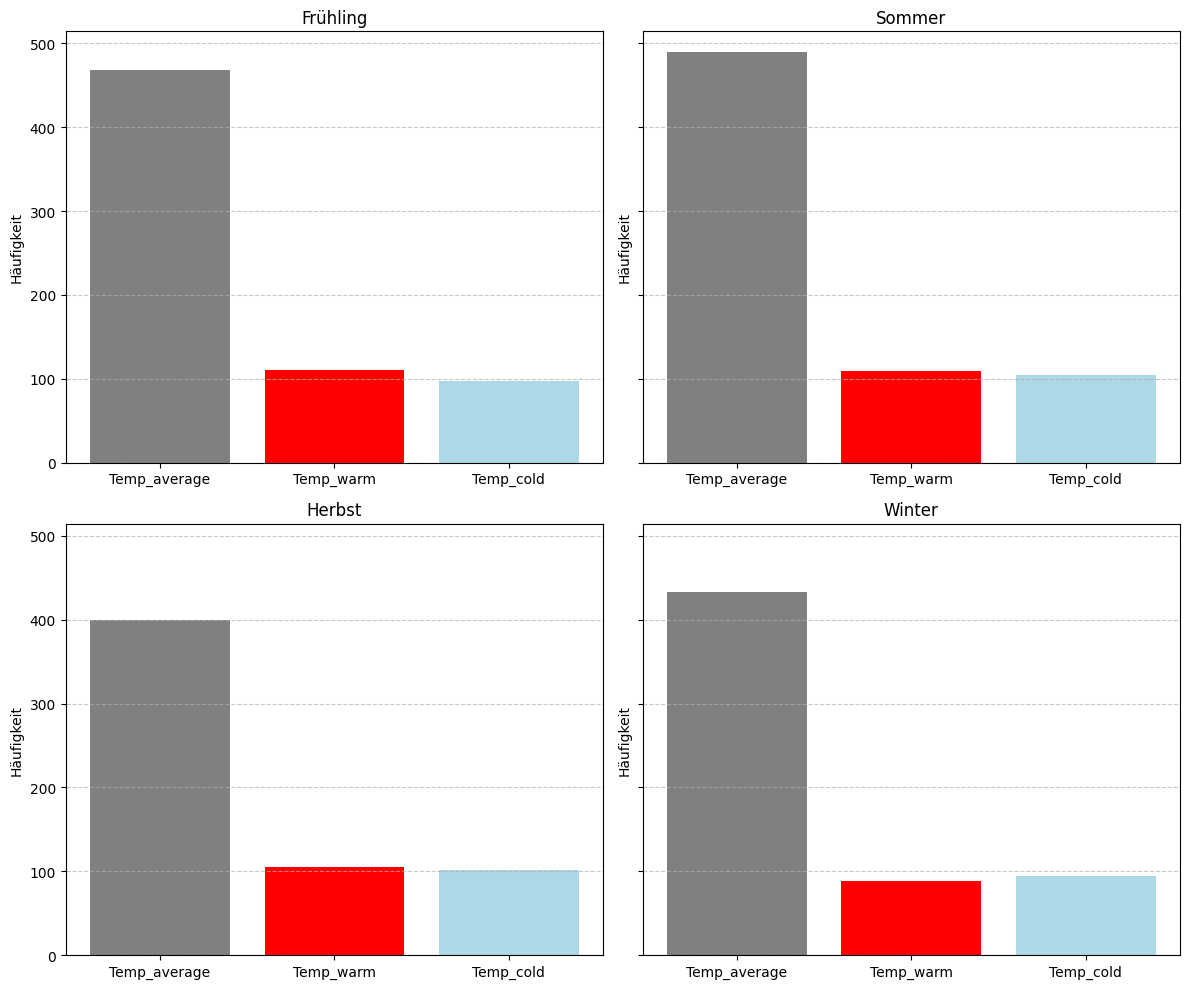

In [7]:
import matplotlib.pyplot as plt

# Häufigkeiten der Kategorien pro Jahreszeit berechnen
season_categories = df_wetter.groupby('Jahreszeit')[['Temp_average', 'Temp_warm', 'Temp_cold']].sum()

# Plot erstellen
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()

season_order = ['Frühling', 'Sommer', 'Herbst', 'Winter']

for i, season in enumerate(season_order):
    if season in season_categories.index:
        season_data = season_categories.loc[season]
        axes[i].bar(season_data.index, season_data.values, color=['grey', 'red', 'lightblue'])
        axes[i].set_title(f'{season}')
        axes[i].set_ylabel('Häufigkeit')
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


##### Darstellung der Temperaturdaten nach Jahreszeiten:

Detaillierte statistische Zusammenfassung:

Winter:
Mean: 3.92
Median: 4.20
Std: 3.84
Min: -10.25
Max: 13.41


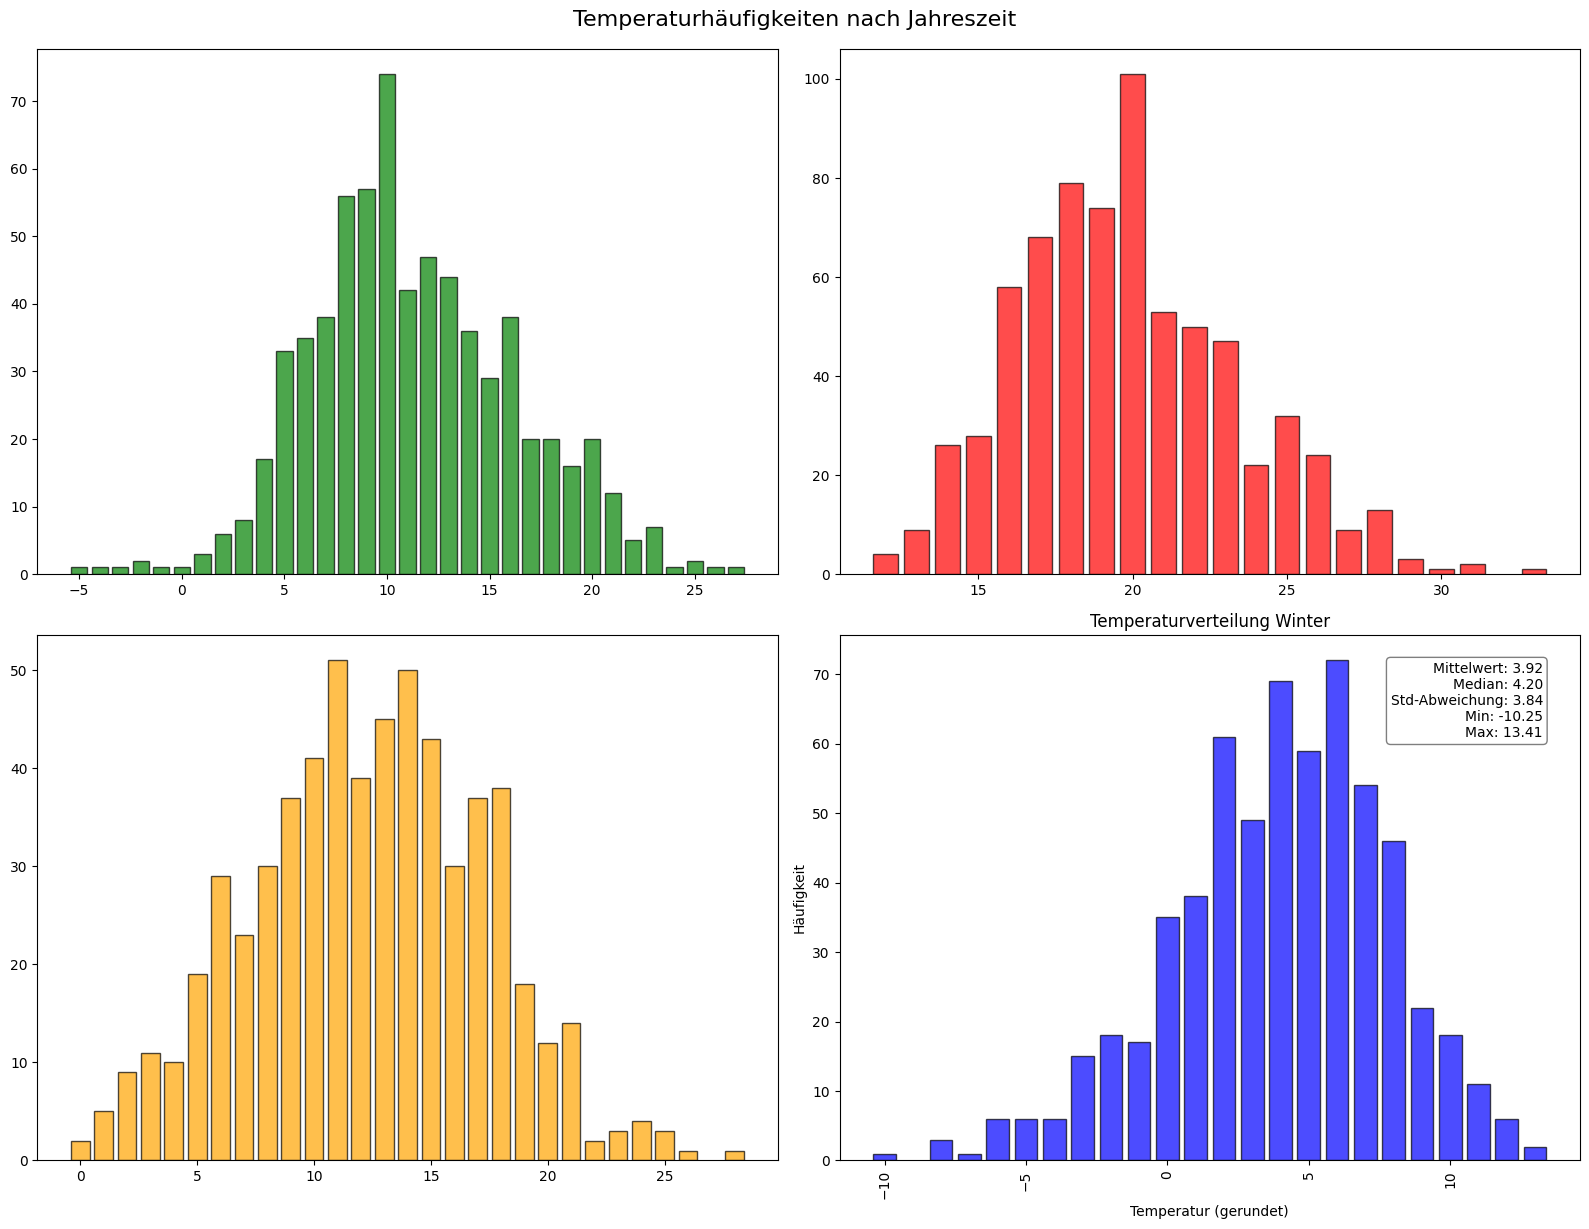

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a sample DataFrame (replace this with your actual data loading)
data = df_wetter

# Color palette for seasons
season_colors = {
    'Frühling': 'green',
    'Sommer': 'red',
    'Herbst': 'orange',
    'Winter': 'blue'
}

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.ravel()  # Flatten the 2x2 array for easy iteration

# Detailed statistics storage
season_stats = {}

# Create histogram for each season
for i, season in enumerate(['Frühling', 'Sommer', 'Herbst', 'Winter']):
    # Filter data for the specific season
    season_temps = data[data['Jahreszeit'] == season]['Temperatur']
    
    # Round temperatures to integers and count their frequencies
    temp_counts = season_temps.round().astype(int).value_counts().sort_index()

    # Create bar plot with unique bars for each temperature
    axs[i].bar(temp_counts.index, temp_counts.values, 
           color=season_colors[season], 
           alpha=0.7,
           edgecolor='black')

# Add this condition to rotate labels if needed
if len(temp_counts) > 10:
    axs[i].tick_params(axis='x', rotation=90)

    # Calculate statistics
    season_stats[season] = {
        'mean': season_temps.mean(),
        'median': season_temps.median(),
        'std': season_temps.std(),
        'min': season_temps.min(),
        'max': season_temps.max()
    }
    
    # Set title and labels
    axs[i].set_title(f'Temperaturverteilung {season}', fontsize=12)
    axs[i].set_xlabel('Temperatur (gerundet)', fontsize=10)
    axs[i].set_ylabel('Häufigkeit', fontsize=10)
    
    # Add statistical annotations
    stats_text = (f"Mittelwert: {season_stats[season]['mean']:.2f}\n"
                  f"Median: {season_stats[season]['median']:.2f}\n"
                  f"Std-Abweichung: {season_stats[season]['std']:.2f}\n"
                  f"Min: {season_stats[season]['min']:.2f}\n"
                  f"Max: {season_stats[season]['max']:.2f}")
    axs[i].text(0.95, 0.95, stats_text, 
                transform=axs[i].transAxes, 
                verticalalignment='top', 
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Adjust layout and add overall title
plt.tight_layout()
fig.suptitle('Temperaturhäufigkeiten nach Jahreszeit', fontsize=16, y=1.02)

# Print detailed statistics to console
print("Detaillierte statistische Zusammenfassung:")
for season, stats in season_stats.items():
    print(f"\n{season}:")
    for stat_name, stat_value in stats.items():
        print(f"{stat_name.capitalize()}: {stat_value:.2f}")

plt.show()

Detaillierte statistische Zusammenfassung:

Frühling:
Mittelwert: 11.29
Standardabweichung: 5.02
Temperaturintervalle:
  Kalt: -4.96 bis 6.27
  Durchschnitt: 6.27 bis 16.30
  Warm: 16.30 bis 26.86

Sommer:
Mittelwert: 19.84
Standardabweichung: 3.54
Temperaturintervalle:
  Kalt: 11.56 bis 16.29
  Durchschnitt: 16.29 bis 23.38
  Warm: 23.38 bis 32.67

Herbst:
Mittelwert: 12.32
Standardabweichung: 5.01
Temperaturintervalle:
  Kalt: -0.28 bis 7.31
  Durchschnitt: 7.31 bis 17.33
  Warm: 17.33 bis 27.88

Winter:
Mittelwert: 3.92
Standardabweichung: 3.84
Temperaturintervalle:
  Kalt: -10.25 bis 0.08
  Durchschnitt: 0.08 bis 7.75
  Warm: 7.75 bis 13.41


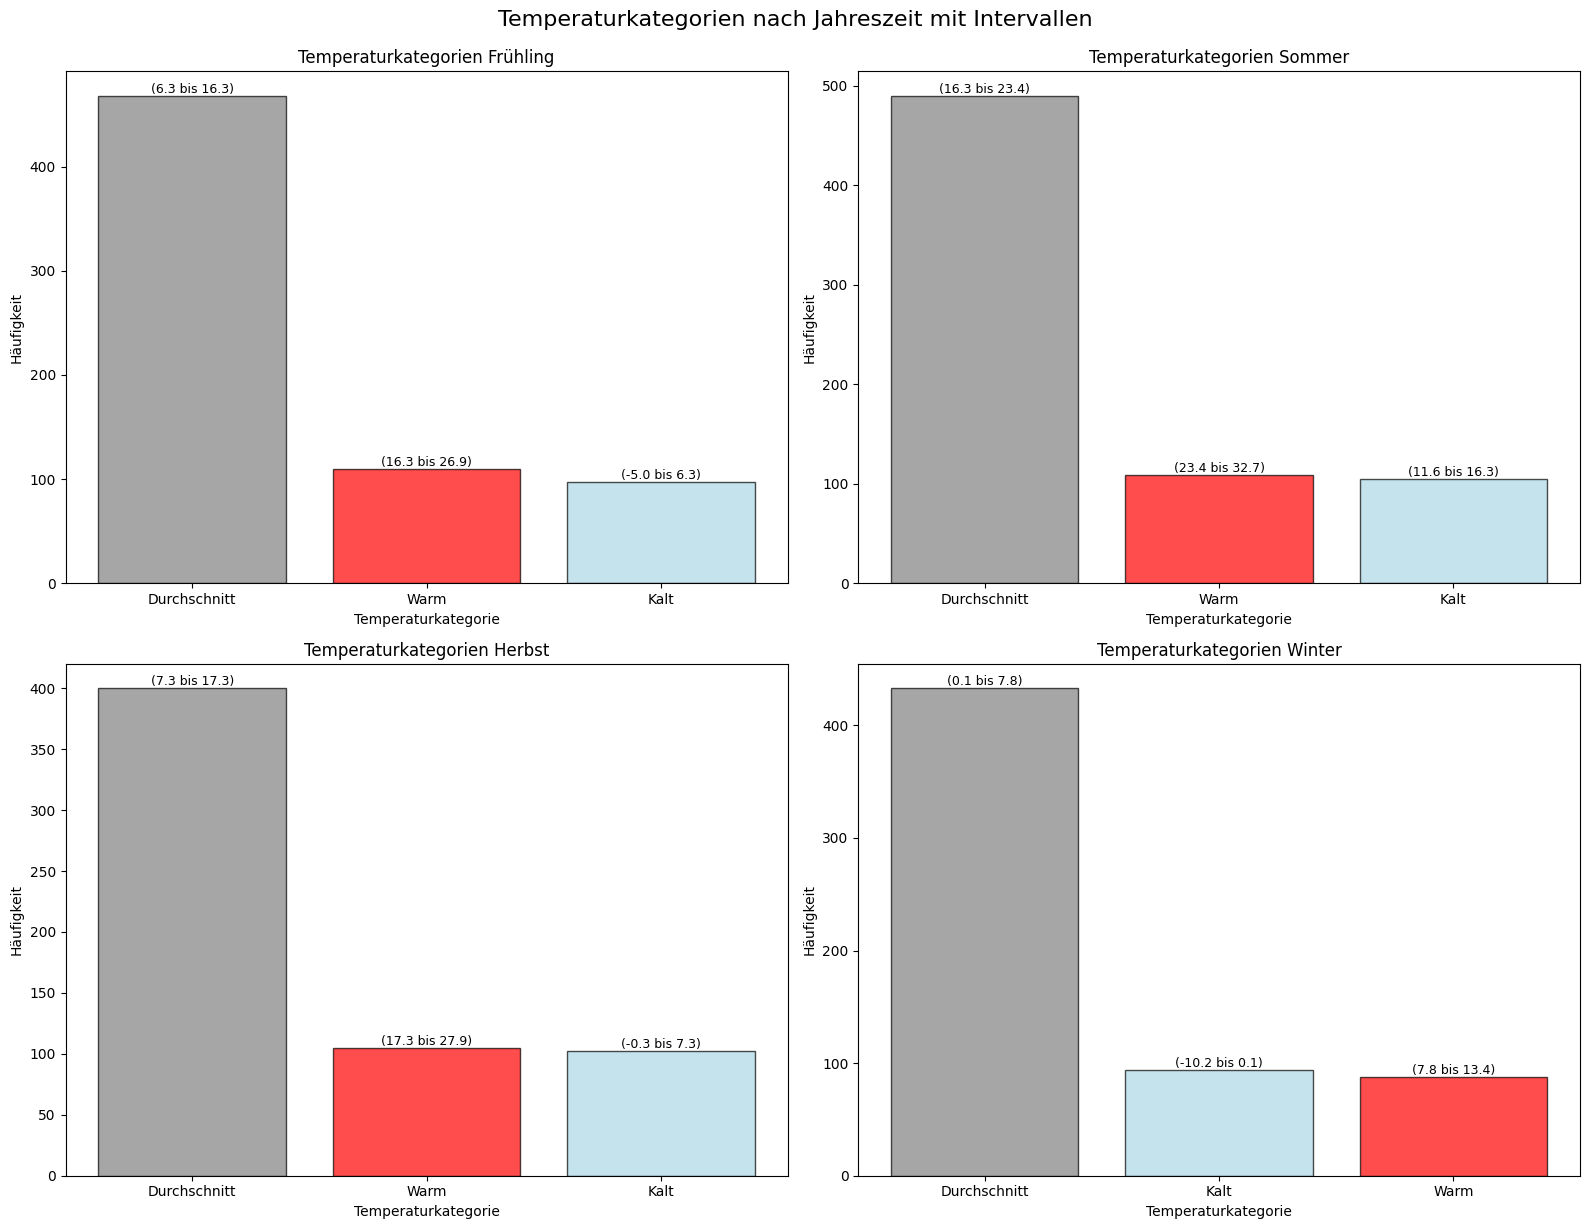

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a sample DataFrame (replace this with your actual data loading)
data = df_wetter

# Color palette for temperature categories
temp_colors = {
    'Kalt': 'lightblue',
    'Durchschnitt': 'grey',
    'Warm': 'red'
}

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.ravel()  # Flatten the 2x2 array for easy iteration

# Detailed statistics storage
season_stats = {}

# Categorize temperatures for each season
for i, season in enumerate(['Frühling', 'Sommer', 'Herbst', 'Winter']):
    # Filter data for the specific season
    season_temps = data[data['Jahreszeit'] == season]['Temperatur']
    
    # Calculate mean and standard deviation
    mean_temp = season_temps.mean()
    std_temp = season_temps.std()
    
    # Define temperature category bounds
    cold_min = season_temps.min()
    cold_max = mean_temp - std_temp
    
    durchschnitt_min = cold_max
    durchschnitt_max = mean_temp + std_temp
    
    warm_min = durchschnitt_max
    warm_max = season_temps.max()
    
    # Store season and category statistics
    season_stats[season] = {
        'Mittelwert': mean_temp,
        'Standardabweichung': std_temp,
        'Kategorien': {
            'Kalt': (cold_min, cold_max),
            'Durchschnitt': (durchschnitt_min, durchschnitt_max),
            'Warm': (warm_min, warm_max)
        }
    }
    
    # Categorize temperatures
    def categorize_temp(temp):
        if temp < (mean_temp - std_temp):
            return 'Kalt'
        elif temp > (mean_temp + std_temp):
            return 'Warm'
        else:
            return 'Durchschnitt'
    
    # Apply categorization
    season_temps_cat = season_temps.apply(categorize_temp)
    
    # Count frequencies of temperature categories
    temp_cat_counts = season_temps_cat.value_counts()
    
    # Create bar plot for temperature categories
    bars = axs[i].bar(temp_cat_counts.index, temp_cat_counts.values, 
               color=[temp_colors[cat] for cat in temp_cat_counts.index], 
               alpha=0.7,
               edgecolor='black')
    
    # Set title and labels
    axs[i].set_title(f'Temperaturkategorien {season}', fontsize=12)
    axs[i].set_xlabel('Temperaturkategorie', fontsize=10)
    axs[i].set_ylabel('Häufigkeit', fontsize=10)
    
    # Add interval information to bars
    for bar, category in zip(bars, temp_cat_counts.index):
        interval = season_stats[season]['Kategorien'][category]
        axs[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                    f'({interval[0]:.1f} bis {interval[1]:.1f})', 
                    ha='center', va='bottom', fontsize=9)

# Adjust layout and add overall title
plt.tight_layout()
fig.suptitle('Temperaturkategorien nach Jahreszeit mit Intervallen', fontsize=16, y=1.02)

# Print detailed statistics to console
print("Detaillierte statistische Zusammenfassung:")
for season, stats in season_stats.items():
    print(f"\n{season}:")
    print(f"Mittelwert: {stats['Mittelwert']:.2f}")
    print(f"Standardabweichung: {stats['Standardabweichung']:.2f}")
    print("Temperaturintervalle:")
    for category, (min_temp, max_temp) in stats['Kategorien'].items():
        print(f"  {category}: {min_temp:.2f} bis {max_temp:.2f}")

plt.show()